In [1]:

import numpy as np
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
import plotly.express as px

class Points:
    def __init__(self, data):
        """
        Inicializa la clase Points con los datos proporcionados.
        data: conjunto de datos con los vectores de píxeles.
        """
        self.points = data
        self.dist_matrix = None  
    
    def get_num_points(self):
        """
        Retorna el número de puntos (imágenes).
        """
        return len(self.points)

    def calcular_promedios_rgb(self):
        """
        Calcula los promedios de los canales RGB para cada imagen.
        
        Retorna:
        np.array: Un array con los promedios de los canales RGB por cada imagen.
        """
        promedios_rgb = []
        
        for fila in self.points:
            # Separar los canales Rojo, Verde y Azul de la fila
            red = fila[:1024].reshape(32, 32)
            green = fila[1024:2048].reshape(32, 32)
            blue = fila[2048:].reshape(32, 32)
            
            # Calcular el promedio de cada canal
            avg_red = np.mean(red)
            avg_green = np.mean(green)
            avg_blue = np.mean(blue)
            
            # Agregar los promedios como un vector [avg_red, avg_green, avg_blue]
            promedios_rgb.append([avg_red, avg_green, avg_blue])
        
        return np.array(promedios_rgb)

    def precalcular_distancias(self, puntos_rgb):
        """
        Precalcula la matriz de distancias entre todos los puntos para optimizar el cálculo del medoid.
        
        Parámetros:
        puntos_rgb (np.array): Matriz con los promedios RGB por cada imagen.
        """
        self.dist_matrix = cdist(puntos_rgb, puntos_rgb, 'euclidean')

    def calcular_costo_total(self, clusters):
        """
        Calcula el costo total del clustering como la suma de distancias entre los puntos y sus medoids.
        
        Parámetros:
        clusters (list): Lista de clusters, donde cada cluster es una lista de índices de los puntos.
        
        Retorna:
        float: El costo total del clustering.
        """
        costo_total = 0
        
        for cluster in clusters:
            # Calcular el medoid del cluster
            medoid_idx = self.calcular_medoid(cluster)
            
            # Sumar las distancias de todos los puntos en el cluster a su medoid
            for idx in cluster:
                costo_total += self.dist_matrix[idx, medoid_idx]
        
        return costo_total

    def calcular_medoid(self, cluster):
        """
        Calcula el medoid de un cluster 
        
        Parámetros:
        cluster (list): Lista de índices de los puntos que pertenecen al cluster.
        
        Retorna:
        int: El índice del punto medoid.
        """
        mejor_idx = None
        mejor_distancia_total = float('inf')

        # Iterar sobre cada punto del cluster para encontrar el medoid
        for idx in cluster:
            
            distancia_total = sum(self.dist_matrix[idx, otro_idx] for otro_idx in cluster)
            
            if distancia_total < mejor_distancia_total:
                mejor_distancia_total = distancia_total
                mejor_idx = idx
        
        return mejor_idx

    def mbsas(self, puntos_rgb, q, threshold):
        """
        Implementa el algoritmo MBSAS para agrupar los puntos en función de los colores (RGB)
        y la distancia euclidiana.
        
        Parámetros:
        puntos_rgb (np.array): Matriz con los promedios RGB por cada imagen.
        q (int): Número máximo de clusters permitidos.
        threshold (float): Umbral de distancia para la formación de nuevos clusters.
        
        Retorna:
        list: Lista de clusters.
        """
        clusters = []
        representatives = []  # Lista para almacenar los medoids
        assigned = [False] * self.get_num_points()

        # Fase 1: Determinación de Clusters
        clusters.append([0])  # El primer punto inicia el primer cluster
        representatives.append(0)  # El primer punto es el representante inicial (medoid)
        assigned[0] = True

        for i in range(1, self.get_num_points()):
            # Calcular la distancia euclidiana entre el punto y los medoids de los clusters existentes
            distances = [self.dist_matrix[i, rep] for rep in representatives]
            min_distance = min(distances)
            nearest_cluster_index = distances.index(min_distance)

            # Si la distancia mínima es mayor que el threshold y no hemos alcanzado el máximo de clusters, crear un nuevo cluster
            if min_distance > threshold and len(clusters) < q:
                clusters.append([i])
                representatives.append(i)  # El representante inicial del nuevo cluster es el propio punto
                assigned[i] = True
            else:
                # Agregar el punto al cluster más cercano
                clusters[nearest_cluster_index].append(i)

                # Calcular el nuevo medoid del cluster
                new_medoid = self.calcular_medoid(clusters[nearest_cluster_index])
                representatives[nearest_cluster_index] = new_medoid

        # Calcular el costo total del clustering
        costo_total = self.calcular_costo_total(clusters)
        print(f"Costo total del clustering: {costo_total}")

        return clusters, representatives

    def bsas(self, puntos_rgb, q, threshold):
        """
        Implementa el algoritmo BSAS para agrupar los puntos en función de los colores (RGB)
        y la distancia euclidiana.
        
        Parámetros:
        puntos_rgb (np.array): Matriz con los promedios RGB por cada imagen.
        q (int): Número máximo de clusters permitidos.
        threshold (float): Umbral de distancia para la formación de nuevos clusters.
        
        Retorna:
        list: Lista de clusters.
        """
        clusters = []
        representatives = []  # Lista para almacenar los medoids

        # Iniciar el primer cluster
        clusters.append([0])  # El primer punto inicia el primer cluster
        representatives.append(0)  # El primer punto es el representante inicial (medoid)

        for i in range(1, self.get_num_points()):
            # Calcular la distancia euclidiana entre el punto y los representantes de los clusters existentes
            distances = [self.dist_matrix[i, rep] for rep in representatives]
            min_distance = min(distances)
            nearest_cluster_index = distances.index(min_distance)

            if min_distance > threshold and len(clusters) < q:
                # Crear un nuevo cluster si la distancia es mayor al umbral y aún es posible agregar más clusters
                clusters.append([i])
                representatives.append(i)  # El nuevo punto es el representante del nuevo cluster
            else:
                # Agregar el punto al cluster más cercano
                clusters[nearest_cluster_index].append(i)

                # Calcular el nuevo medoid del cluster
                new_medoid = self.calcular_medoid(clusters[nearest_cluster_index])
                representatives[nearest_cluster_index] = new_medoid

        return clusters, representatives

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [8]:
import pickle

# Cargar los datos de CIFAR-10
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Lista de archivos batch que quieres cargar
###batch_files = ["data_batch_1", "data_batch_2", "data_batch_3", "data_batch_4", "data_batch_5"]
batch_files = ["data_batch_1"]
# Inicializar listas vacías para combinar los datos y etiquetas
combined_data = []
combined_labels = []
combined_filenames = []

# Cargar cada batch y agregar sus datos y etiquetas a las listas
for batch_file in batch_files:
    batch = unpickle(batch_file)
    combined_data.append(batch[b'data'])
    combined_labels.append(batch[b'labels'])
    combined_filenames += batch[b'filenames']

# Concatenar todos los datos y etiquetas en un solo array
combined_data = np.concatenate(combined_data)
combined_labels = np.concatenate(combined_labels)

Costo total del clustering: 102382.98993004776
El centroide del cluster 0 es la imagen con índice 1870 (clase original: 2)
El centroide del cluster 1 es la imagen con índice 1853 (clase original: 1)
El centroide del cluster 2 es la imagen con índice 1926 (clase original: 0)


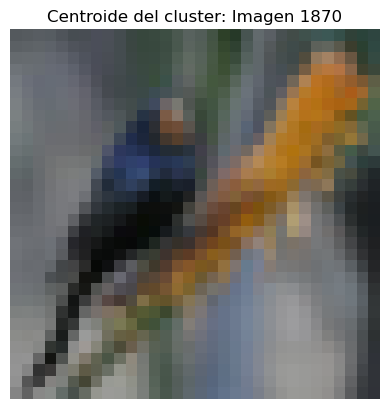

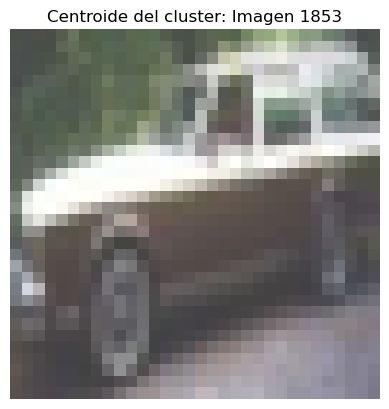

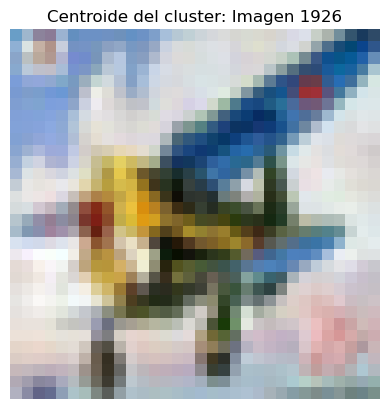

Tiempo de ejecución secuencial: 349.99989128112793 segundos


In [10]:
import time

start_time = time.time()

# Coloca aquí el código secuencial que quieres medir
# Ejemplo: Cálculo de promedios RGB y clustering
clases_interes = [0, 1, 2]  # Clases de interés: 1, 2
indices_clases_interes = [i for i in range(len(combined_labels)) if combined_labels[i] in clases_interes]

# Filtrar los datos y las etiquetas
filtered_data = combined_data[indices_clases_interes]
filtered_labels = [combined_labels[i] for i in indices_clases_interes]

# Crear una instancia de la clase Points con los datos filtrados
puntos_obj = Points(filtered_data)

# Calcular los promedios RGB para cada imagen
puntos_rgb = puntos_obj.calcular_promedios_rgb()

# Precalcular la matriz de distancias
puntos_obj.precalcular_distancias(puntos_rgb)

# Aplicar MBSAS con los promedios RGB para las clases seleccionadas
clusters_mbsas, representatives = puntos_obj.mbsas(puntos_rgb, q=3, threshold=20.0)

# Imprimir los centroides (medoids) de los clusters formados
for i, medoid_idx in enumerate(representatives):
    print(f"El centroide del cluster {i} es la imagen con índice {medoid_idx} (clase original: {filtered_labels[medoid_idx]})")

# Función para visualizar la imagen del centroide
def visualizar_centroide(centroide_idx):
    red = filtered_data[centroide_idx][:1024].reshape(32, 32)
    green = filtered_data[centroide_idx][1024:2048].reshape(32, 32)
    blue = filtered_data[centroide_idx][2048:].reshape(32, 32)
    imagen_rgb = np.stack([red, green, blue], axis=2)

    plt.imshow(imagen_rgb)
    plt.title(f"Centroide del cluster: Imagen {centroide_idx}")
    plt.axis('off')
    plt.show()

# Visualizar el centroide de cada cluster formado
for i in range(len(representatives)):
    visualizar_centroide(representatives[i])

end_time = time.time()
print(f"Tiempo de ejecución secuencial: {end_time - start_time} segundos")


In [ ]:
import threading
import time

def calcular_rgb_concurrente(data_slice, output, index):
    try:
        output[index] = puntos_obj.calcular_promedios_rgb(data_slice)
    except Exception as e:
        output[index] = []
        print(f"Error en el hilo {index}: {e}")

def precalcular_distancias_concurrente(rgb_data, output, index):
    try:
        output[index] = puntos_obj.precalcular_distancias(rgb_data)
    except Exception as e:
        output[index] = []
        print(f"Error en el hilo {index}: {e}")

def aplicar_mbsas_concurrente(rgb_data, q, threshold, clusters_output, representatives_output, index):
    try:
        clusters, representatives = puntos_obj.mbsas(rgb_data, q, threshold)
        clusters_output[index] = clusters
        representatives_output[index] = representatives
    except Exception as e:
        clusters_output[index] = []
        representatives_output[index] = []
        print(f"Error en el hilo {index}: {e}")

# Inicializar variables de control
num_threads = 4
chunk_size = len(filtered_data) // num_threads
threads = []
rgb_outputs = [None] * num_threads
dist_outputs = [None] * num_threads
clusters_outputs = [None] * num_threads
representatives_outputs = [None] * num_threads

start_time = time.time()

# Calcular RGBs en paralelo
for i in range(num_threads):
    start = i * chunk_size
    end = len(filtered_data) if i == num_threads - 1 else start + chunk_size
    thread = threading.Thread(target=calcular_rgb_concurrente, args=(filtered_data[start:end], rgb_outputs, i))
    threads.append(thread)
    thread.start()

for thread in threads:
    thread.join()

# Aplanar los resultados RGB
puntos_rgb = [item for sublist in rgb_outputs if sublist for item in sublist]

# Precalcular distancias en paralelo
threads = []
for i in range(num_threads):
    thread = threading.Thread(target=precalcular_distancias_concurrente, args=(puntos_rgb, dist_outputs, i))
    threads.append(thread)
    thread.start()

for thread in threads:
    thread.join()

# Aplicar MBSAS en paralelo
threads = []
for i in range(num_threads):
    thread = threading.Thread(target=aplicar_mbsas_concurrente, args=(puntos_rgb, 3, 20.0, clusters_outputs, representatives_outputs, i))
    threads.append(thread)
    thread.start()

for thread in threads:
    thread.join()



# Visualizar los centroides de cada cluster formado
for cluster_list in representatives_outputs:
    for i, medoid_idx in enumerate(cluster_list):
        if medoid_idx is not None:
            print(f"El centroide del cluster {i} es la imagen con índice {medoid_idx} (clase original: {filtered_labels[medoid_idx]})")
            visualizar_centroide(medoid_idx)
end_time = time.time()
print(f"Tiempo de ejecución con multi-hilos: {end_time - start_time} segundos")


In [ ]:
from multiprocessing import Process, Array, Pool

start_time = time.time()

def calcular_distancias_multiprocess(data_slice):
    return puntos_obj.precalcular_distancias(data_slice)


num_processes = 4
pool = Pool(processes=num_processes)
results = pool.map(puntos_obj.calcular_promedios_rgb, np.array_split(filtered_data, num_processes))

puntos_rgb = np.concatenate(results)
puntos_obj.precalcular_distancias(puntos_rgb)



clusters_mbsas, representatives = puntos_obj.mbsas(puntos_rgb, q=3, threshold=20.0)
for i, medoid_idx in enumerate(representatives):
    print(f"El centroide del cluster {i} es la imagen con índice {medoid_idx} (clase original: {filtered_labels[medoid_idx]})")
    visualizar_centroide(medoid_idx)



end_time = time.time()
print(f"Tiempo de ejecución secuencial: {end_time - start_time} segundos")
